# iNaturalist 2019 EDA + DL

As part of the FGVC6 workshop at CVPR 2019, Kaggle is conducting the iNat Challenge 2019, the large scale species classification competition, sponsored by Microsoft. It is estimated that the natural world contains several million species of plants and animals. Without expert knowledge, many of these species are extremely difficult to accurately classify due to their visual similarity. The goal of this competition is to push the state of the art in automatic image classification for real world data that features a large number of fine-grained categories.

This Kernel will use the idea of "Transfer Learning", various pre-trained model will be used be used for the problem of multiclassification.

Kudos and main ideas / reference: 

- [hsinwenchang/keras-data-augmentation-visualize](https://www.kaggle.com/hsinwenchang/keras-data-augmentation-visualize/notebook)
- [ateplyuk/inat2019-starter-keras-efficientnet](https://www.kaggle.com/ateplyuk/inat2019-starter-keras-efficientnet)

### Loading the necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

['train2019.json', 'train_val2019', 'val2019.json', 'test2019', 'kaggle_sample_submission.csv', 'test2019.json']


Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

### Train data

In [2]:
ann_file = '../input/train2019.json'
with open(ann_file) as data_file:
        train_anns = json.load(data_file)

In [3]:
train_anns_df = pd.DataFrame(train_anns['annotations'])[['image_id','category_id']]
train_img_df = pd.DataFrame(train_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
df_train_file_cat = pd.merge(train_img_df, train_anns_df, on='image_id')
df_train_file_cat['category_id']=df_train_file_cat['category_id'].astype(str)
df_train_file_cat.head()

,image_id,file_name,category_id
0,0,train_val2019/Plants/400/d1322d13ccd856eb4236c...,400
1,1,train_val2019/Plants/570/15edbc1e2ef000d8ace48...,570
2,2,train_val2019/Reptiles/167/c87a32e8927cbf4f06d...,167
3,3,train_val2019/Birds/254/9fcdd1d37e96d8fd94dfdc...,254
4,4,train_val2019/Plants/739/ffa06f951e99de9d220ae...,739


In [4]:
df_train_file_cat.shape

(265213, 3)

In [5]:
len(df_train_file_cat['category_id'].unique())

1010

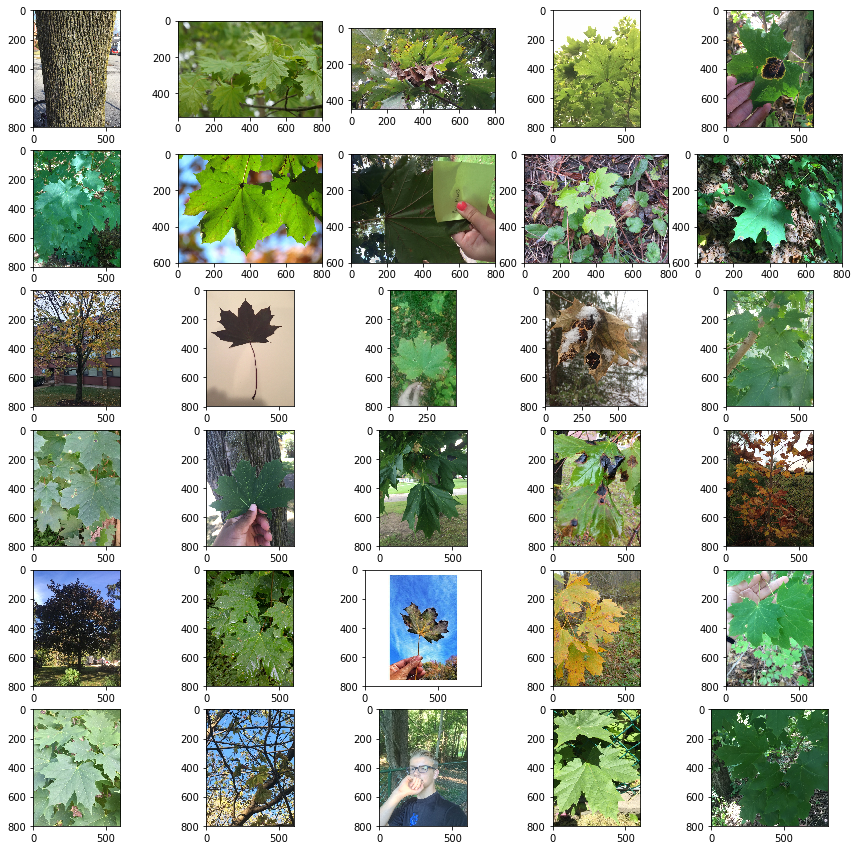

In [6]:
# Example of images for category_id = 400
img_names = df_train_file_cat[df_train_file_cat['category_id']=='400']['file_name'][:30]

plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
    img = cv2.imread("input/%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(6, 5, i)
    plt.imshow(img)
    i += 1
plt.show()

### Validation data

In [7]:
valid_ann_file = 'input/val2019.json'
with open(valid_ann_file) as data_file:
        valid_anns = json.load(data_file)

In [8]:
valid_anns_df = pd.DataFrame(valid_anns['annotations'])[['image_id','category_id']]
valid_anns_df.head()

,image_id,category_id
0,265213,644
1,265214,597
2,265215,883
3,265216,300
4,265217,881


In [9]:
valid_img_df = pd.DataFrame(valid_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
valid_img_df.head()

,image_id,file_name
0,265213,train_val2019/Plants/644/716a69838526f3ada3b2f...
1,265214,train_val2019/Plants/597/0942cc64d2e759c5ee059...
2,265215,train_val2019/Plants/883/acfdbfd9fa675f1c84558...
3,265216,train_val2019/Birds/300/5f3194ff536c7dd31d80b7...
4,265217,train_val2019/Plants/881/76acaf0b2841f91982d21...


In [10]:
df_valid_file_cat = pd.merge(valid_img_df, valid_anns_df, on='image_id')
df_valid_file_cat['category_id']=df_valid_file_cat['category_id'].astype(str)
df_valid_file_cat.head()

,image_id,file_name,category_id
0,265213,train_val2019/Plants/644/716a69838526f3ada3b2f...,644
1,265214,train_val2019/Plants/597/0942cc64d2e759c5ee059...,597
2,265215,train_val2019/Plants/883/acfdbfd9fa675f1c84558...,883
3,265216,train_val2019/Birds/300/5f3194ff536c7dd31d80b7...,300
4,265217,train_val2019/Plants/881/76acaf0b2841f91982d21...,881


In [11]:
nb_classes = 1010
batch_size = 128
img_size = 150
nb_epochs = 5

### Oversampling

In [12]:
#from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(random_state=0)
#X_resampled, y_resampled = ros.fit_resample(df_train_file_cat[["image_id", "file_name"]], df_train_file_cat["category_id"])

#train_df = pd.DataFrame(X_resampled, columns=["image_id", "file_name"])
#train_df["category_id"] = y_resampled

here I applied Data Augmentation technic from [Udacity](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c04_exercise_flowers_with_data_augmentation_solution.ipynb#scrollTo=UOoVpxFwVrWy) as following:
- random 45 degree rotation
- random zoom of up to 50%
- random horizontal flip
- width shift of 0.15
- height shfit of 0.15

In [13]:
%%time
train_datagen=ImageDataGenerator(rescale=1./255, rotation_range=45, 
                    width_shift_range=.15, 
                    height_shift_range=.15, 
                    horizontal_flip=True, 
                    zoom_range=0.5)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=df_train_file_cat,
    directory="../input/train_val2019",
    x_col="file_name",
    y_col="category_id",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size))

Found 265213 validated image filenames belonging to 1010 classes.
CPU times: user 5.08 s, sys: 6.88 s, total: 12 s
Wall time: 1min 37s


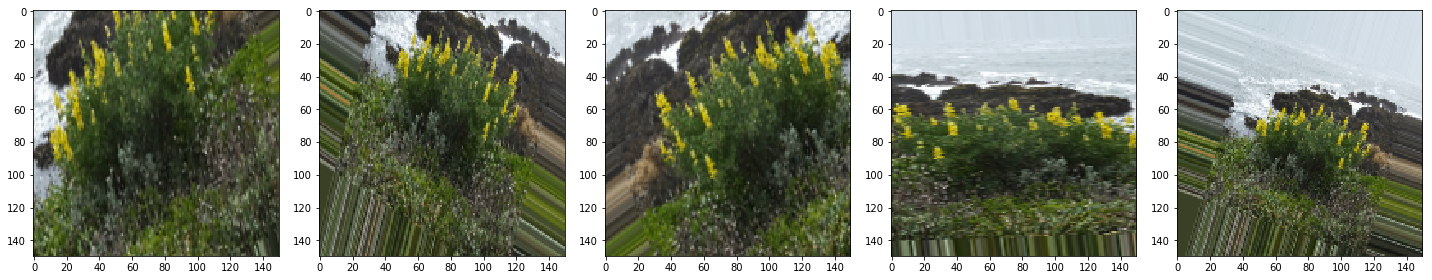

In [14]:
# udacity_intro_to_tensorflow_for_deep_learning/l05c04_exercise_flowers_with_data_augmentation_solution.ipynb#scrollTo=jqb9OGoVKIOi
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [15]:
%%time
test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=test_datagen.flow_from_dataframe(    
    dataframe=df_valid_file_cat,    
    directory="../input/train_val2019",
    x_col="file_name",
    y_col="category_id",
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",    
    target_size=(img_size,img_size))

Found 3030 validated image filenames belonging to 1010 classes.
CPU times: user 44 ms, sys: 104 ms, total: 148 ms
Wall time: 995 ms


In [16]:
import gc
gc.collect();

### Model

I have applied various transfer learning models in order to see which has the best performance, since the numerous categorical data and the little number of cases 

In [17]:
#from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications.nasnet import NASNetLarge
#from keras.applications.densenet import DenseNet121
from keras.applications.xception import Xception

#model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
model_name = "Xception"

83689472/83683744 [==============================] - 1s 0us/step


In [18]:
#Adding custom layers 
model_final = Sequential()
model_final.add(model)
model_final.add(Flatten())
model_final.add(Dense(1024, activation='relu'))
model_final.add(Dropout(0.5))
model_final.add(Dense(nb_classes, activation='softmax'))

model_final.compile(optimizers.rmsprop(lr=0.0001, decay=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
#Callbacks

checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [20]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              52429824  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1010)              1035250   
Total params: 74,326,554
Trainable params: 74,272,026
Non-trainable params: 54,528
_________________________________________________________________


In [21]:
%%time
history = model_final.fit_generator(generator=train_generator, 
                    steps_per_epoch=80,
                    validation_data=valid_generator,
                    validation_steps=40,
                    epochs=nb_epochs,
                    callbacks = [checkpoint, early],                
                    verbose=1)

Epoch 1/5
80/80 [==============================] - 305s 4s/step - loss: 6.8596 - acc: 0.0046 - val_loss: 6.8276 - val_acc: 0.0106

Epoch 00001: val_loss improved from inf to 6.82760, saving model to Xception
Epoch 2/5
80/80 [==============================] - 260s 3s/step - loss: 6.4234 - acc: 0.0224 - val_loss: 6.5579 - val_acc: 0.0262

Epoch 00002: val_loss improved from 6.82760 to 6.55787, saving model to Xception
Epoch 3/5
80/80 [==============================] - 260s 3s/step - loss: 5.9502 - acc: 0.0438 - val_loss: 6.3212 - val_acc: 0.0425

Epoch 00003: val_loss improved from 6.55787 to 6.32118, saving model to Xception
Epoch 4/5
80/80 [==============================] - 272s 3s/step - loss: 5.5557 - acc: 0.0616 - val_loss: 6.1166 - val_acc: 0.0622

Epoch 00004: val_loss improved from 6.32118 to 6.11657, saving model to Xception
Epoch 5/5
80/80 [==============================] - 258s 3s/step - loss: 5.2626 - acc: 0.0827 - val_loss: 5.9535 - val_acc: 0.0679

Epoch 00005: val_loss imp

In [22]:
import gc
gc.collect();

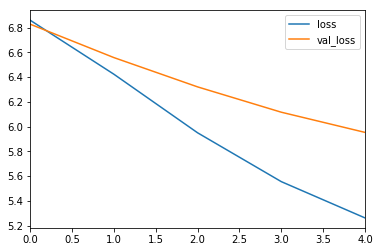

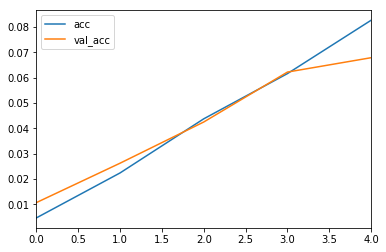

In [23]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [24]:
test_ann_file = '../input/test2019.json'
with open(test_ann_file) as data_file:
        test_anns = json.load(data_file)

In [25]:
test_img_df = pd.DataFrame(test_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
test_img_df.head()

,image_id,file_name
0,268243,test2019/e295f3c7046b1f1e80c0301401324aa9.jpg
1,268244,test2019/ad3dcbb6846ed0b4dab58d7b1a4210ba.jpg
2,268245,test2019/e697be8e296b4b140cff4f96f85c364f.jpg
3,268246,test2019/7e7ba55e6aa26ba99e814d63b15d0121.jpg
4,268247,test2019/6cb6372079d23702511c06923970f13f.jpg


In [26]:
%%time

test_generator = test_datagen.flow_from_dataframe(      
    
        dataframe=test_img_df,    
    
        directory = "../input/test2019",    
        x_col="file_name",
        target_size = (img_size,img_size),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )

Found 35350 validated image filenames.
CPU times: user 880 ms, sys: 484 ms, total: 1.36 s
Wall time: 12.1 s


### Prediction

In [27]:
gc.collect();

In [28]:
%%time
predict_valid=model_final.predict_generator(valid_generator, steps = np.ceil(valid_generator.samples / valid_generator.batch_size), verbose=1)

24/24 [==============================] - 38s 2s/step
CPU times: user 37 s, sys: 1.48 s, total: 38.5 s
Wall time: 37.7 s


In [29]:
predict_valid_class=np.argmax(predict_valid,axis=1)

In [30]:
len(predict_valid_class)

3030

In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#print(classification_report(valid_generator.classes, predict_valid_class))
print(accuracy_score(valid_generator.classes, predict_valid_class))

0.0019801980198019802


In [32]:
%%time
test_generator.reset()
predict=model_final.predict_generator(test_generator, steps = len(test_generator.filenames), verbose=1)

35350/35350 [==============================] - 626s 18ms/step
CPU times: user 11min 5s, sys: 55 s, total: 12min
Wall time: 10min 26s


In [33]:
predicted_class_indices=np.argmax(predict,axis=1)

In [34]:
gc.collect();

In [35]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [36]:
sam_sub_df = pd.read_csv('../input/kaggle_sample_submission.csv')
sam_sub_df.head()

,id,predicted
0,268243,842
1,268244,139
2,268245,988
3,268246,612
4,268247,468


In [37]:
sam_sub_df.shape

(35350, 2)

In [38]:
filenames=test_generator.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted":predictions})
df_res = pd.merge(test_img_df, results, on='file_name')[['image_id','predicted']]\
    .rename(columns={'image_id':'id'})

df_res.head()

,id,predicted
0,268243,4
1,268244,320
2,268245,392
3,268246,160
4,268247,144


In [39]:
df_res.to_csv("submission.csv",index=False)